Note: based on: https://github.com/arsena-k/discourse_atoms/blob/master/DATM%20Tutorial%20Part%201%20of%201%20-%20Identifying%20Atoms%20-%20for%20Public.ipynb

# Discourse Atom Topic Modeling (DATM) Tutorial 

## Part 1 of 2: Extract Atoms from Word Embedding Trained on your Text Data

* This code is written in Python 3.7.2, and uses Gensim version 3.8.3. 
* This code is provides an the outline of how we identified topics in a word embedding trained on our cleaned data, and then explored the resultings topics. Note that we cannot redistribute the data used in our paper "Integrating Topic Modeling and Word Embedding" in any form, and researchers must apply directly to the Centers for Disease Control and Prevention for access. Details on data access are provided in the paper. We add comments with tips for adapting this code to your data. 

In [1]:
from __future__ import division
import pandas as pd
import math
from gensim.models import coherencemodel
import pickle
from scipy.linalg import norm
from sklearn.preprocessing import normalize
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
import os
from itertools import combinations
import numpy as np
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec, KeyedVectors
from random import seed, sample
import seaborn as sns
from ksvd import ApproximateKSVD 

from tqdm import tqdm

from quality import reconst_qual, topic_diversity, coherence_centroid, coherence_pairwise #written for this jupyter notebook

## Setup

In [ ]:
# Files to import
chosen_wv_model = './models/gensim_model_window7_vector_300'

# Folder to save datm files
datm_folder = './datm_ngrams/' # _ngrams because I first did it without ngrams, if redone could be /datm/ folder

# Output files
results_file = 'data/datm_results.csv' # datm models comparison
chosen_datm_model = './datm_ngrams/250comp5nonzeros_dictionary' # for exploration

In [4]:
currentmodel = KeyedVectors.load(chosen_wv_model)

## Extract Atoms with K-SVD

In [4]:
def do_aksvd(w2vmodel, n_comp, n_nonzeros,  savelocation, save=False ):
    aksvd_t = ApproximateKSVD(n_components=n_comp, transform_n_nonzero_coefs=n_nonzeros) #n_components is number of discourse atoms, if vocab size is smallish, keep this fewer. transform_n is the number of atoms (components) that a word can be a linear combo of
    dictionary_t = aksvd_t.fit(w2vmodel.wv.vectors).components_ # Dictionary is the matrix of discourse atoms.
    gamma_t = aksvd_t.transform(w2vmodel.wv.vectors) #get the gammas, which are the "weights" of each word on a discourse atoms
    #len(dictionary[0]) #check that a discourse-atom vector is still same dimensions as word-vectors, note that norm of the dictionary vecs (atoms) are each 1! 
    if save==True:
        outfile = open(str(savelocation)  + str(n_comp) + 'comp_' + str(n_nonzeros) + 'nonzeros_aksvd','wb')
        pickle.dump(aksvd_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation)  +str(n_comp) + 'comp_' + str(n_nonzeros) + 'nonzeros_dictionary' ,'wb')
        pickle.dump(dictionary_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation)  + str(n_comp) + 'comp_' + str(n_nonzeros) + 'nonzeros_gamma','wb')
        pickle.dump(gamma_t,outfile)
        outfile.close()
    return(dictionary_t, gamma_t)


Select the number of hyperparameters (e.g., number of atoms and/or number of nonzeros) by training models on a range of these hyperparameters and using quality metrics to select the best model

In [ ]:
ntopics= []
nonzeros = []
cohere_pairwise= []
div=[]
sse= []
rmse =[]
r2=[]

In [14]:
for i in tqdm([100, 125, 150, 175, 200, 225, 250, 275, 325, 375, 425,500,600]): 
    for j in [5]: # Arora and A-K both choose 5
        dictionary, gamma = do_aksvd(currentmodel, i, j, datm_folder,  save=True) #varying hyperparameters
        cohere_pairwise.append(coherence_pairwise(currentmodel, dictionary, top_n=25))
        div.append(topic_diversity(currentmodel, dictionary, top_n=25))
        rec= reconst_qual(currentmodel, dictionary, gamma)
        sse.append(rec[0])
        rmse.append(rec[1])
        r2.append(rec[2])
        ntopics.append(i)
        nonzeros.append(j)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [32:16<00:00, 645.35s/it]


In [15]:
quality_results = pd.DataFrame(data={'Components_Topics': ntopics,'Nonzeros': nonzeros,
                'CohereCossim_top25_mean': cohere_pairwise, 'Diversity_top25': div, 
                  'SSE': sse,'RMSE': rmse, 'R2': r2})

In [16]:
quality_results

,Components_Topics,Nonzeros,CohereCossim_top25_mean,Diversity_top25,SSE,RMSE,R2
0,100,5,0.488444,0.987600,3.180565e+06,0.401844,0.461018
1,125,5,0.485211,0.986560,3.062843e+06,0.394337,0.480967
2,150,5,0.477625,0.982400,2.964233e+06,0.387937,0.497678
3,175,5,0.479651,0.968229,2.893005e+06,0.383248,0.509748
4,200,5,0.465154,0.954600,2.831926e+06,0.379181,0.520099
5,225,5,0.464462,0.940622,2.766470e+06,0.374773,0.531191
6,250,5,0.465011,0.942560,2.711728e+06,0.371047,0.540468
7,275,5,0.461898,0.929455,2.659864e+06,0.367481,0.549257
8,325,5,0.464693,0.893785,2.607221e+06,0.363827,0.558178
9,375,5,0.468044,0.880427,2.535976e+06,0.358821,0.570251


In [ ]:
# Not done first time
quality_results.to_csv(results_file, index=False)

[(0.0, 1.0)]

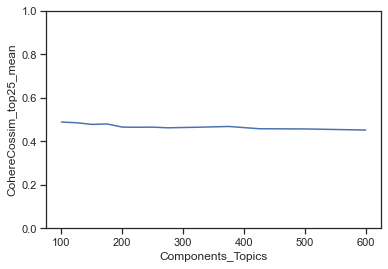

In [17]:
sns.set(style="ticks")
plt=sns.lineplot(x="Components_Topics", y="CohereCossim_top25_mean", data=quality_results, sort=True)
#plt.legend(bbox_to_anchor=(1.3, .5),loc='center right')#, borderaxespad=0.) 
plt.set(ylim=(0,1))
#plt.set(xlim=(0,550))

# Higher coherence is better; more interpretable for humans.

[(0.0, 1.0)]

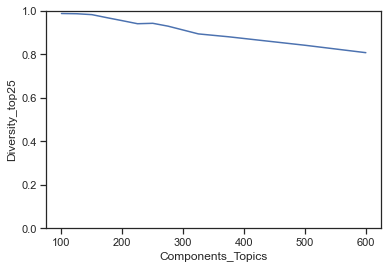

In [18]:
sns.set(style="ticks")
plt=sns.lineplot(x="Components_Topics", y="Diversity_top25", data=quality_results, sort=True)
#plt.legend(bbox_to_anchor=(1.3, .5),loc='center right')#, borderaxespad=0.) 
plt.set(ylim=(0,1))
#plt.set(xlim=(0,550))

# THe higher the value, the less overlap there is between topics. 200 or 250 topics seems best

[(0.0, 1.0)]

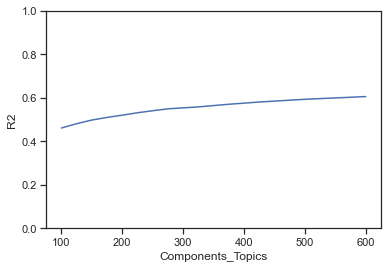

In [19]:
sns.set(style="ticks")
plt=sns.lineplot(x="Components_Topics", y="R2", data=quality_results, sort=True)
#plt.legend(bbox_to_anchor=(1.3, .5),loc='center right')#, borderaxespad=0.) 
plt.set(ylim=(0,1))
#plt.set(xlim=(0,550))

# Marginal gains seem to flatten after 275

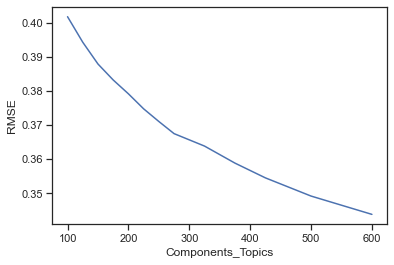

In [20]:
sns.set(style="ticks")
plt=sns.lineplot(x="Components_Topics", y="RMSE", data=quality_results, sort=True)
#plt.legend(bbox_to_anchor=(1.3, .5),loc='center right')#, borderaxespad=0.) 
#plt.set(ylim=(.67, .85))
#plt.set(xlim=(0,550))

# Again 250ish seems where marginal gains get lower

## Exploring the Model and Resulting Topics

In [2]:
with open(chosen_datm_model,'rb') as f:
    mydictionary=pickle.load(f)

Exploring the 25 most similar words to each atom atom and their respective cosine similarities (note that here is where you get a "topic": the distribution of words that characterize an atom vector

In [5]:
for i in range(0, len(mydictionary)): 
    print("Discourse_Atom " + str(i))
    print([j for j in currentmodel.wv.similar_by_vector(mydictionary[i],topn=25)]) #what are the 25 most similar words to the Nth dicourse atom?
    print('\n')

Discourse_Atom 0
[('fantasising', 0.7166740298271179), ('bragged', 0.6901600956916809), ('blathering', 0.6612817049026489), ('ranted', 0.6486988067626953), ('whole_spiel', 0.6483307480812073), ('boasting', 0.6432799696922302), ('blabbing', 0.6417528986930847), ('stop_caring', 0.6373492479324341), ('nobody_cared', 0.6189480423927307), ('nobody_cares', 0.6187320351600647), ('inquire', 0.6117702722549438), ('complaing', 0.6009880900382996), ('gossiping', 0.5967461466789246), ('obsessing', 0.5915422439575195), ('stop_worrying', 0.5860027074813843), ('whinging', 0.5775148272514343), ('*care*', 0.5727991461753845), ('conflicted_feelings', 0.5686595439910889), ('stopped_caring', 0.5677188038825989), ('lied', 0.566866934299469), ('dgaf', 0.561687707901001), ('rants', 0.5616747736930847), ('whined', 0.5536682605743408), ('whines', 0.5511411428451538), ('warned', 0.5496177077293396)]


Discourse_Atom 1
[('poseidon', 0.6350440979003906), ('kingdom', 0.6196103692054749), ('castle', 0.6063692569732

[('blind_eye', 0.7116586565971375), ('tables', 0.7017606496810913), ('brain_off', 0.6733576655387878), ('heel', 0.6142652630805969), ('tide', 0.6077266335487366), ('ash', 0.6031414866447449), ('on/off', 0.5972794890403748), ('90_degrees', 0.5958755016326904), ('dust', 0.5736802816390991), ('mush', 0.5514397621154785), ('wheels', 0.5395271182060242), ('tides', 0.5212962627410889), ('180_degree', 0.5169764161109924), ('upside_down', 0.508465588092804), ('your_brain', 0.5057365298271179), ('my_stomach', 0.5021034479141235), ('plane_invisible', 0.4977681636810303), ('into', 0.493851900100708), ('knob', 0.48195454478263855), ('lights', 0.47138845920562744), ('jet_invisible', 0.47103986144065857), ('sideways', 0.46767041087150574), ('darkside', 0.45845699310302734), ('lever', 0.4455644190311432), ('my_brain', 0.44510453939437866)]


Discourse_Atom 43
[('insanely_strong', 0.5162972211837769), ('**is**', 0.5113242864608765), ('lacks_empathy', 0.5059626698493958), ('afterall', 0.505621671676635

[('something', 0.7120425701141357), ('whatever', 0.705336332321167), ('smth', 0.618445873260498), ('sth', 0.6073458194732666), ('whether', 0.6024130582809448), ('w/e', 0.5847798585891724), ('wether', 0.5697466731071472), ('anything', 0.5638822317123413), ('lack_thereof', 0.5509112477302551), ('anything_else', 0.5474750399589539), ('something..', 0.5399855375289917), ('somthing', 0.5320659875869751), ('somethin', 0.5288845896720886), ('*something*', 0.5171827077865601), ('either', 0.5150669813156128), ('thereabouts', 0.5148173570632935), ('someone_else', 0.5129218101501465), ('what', 0.5008320212364197), ('nothing', 0.5004629492759705), ('decide_whether', 0.4878334701061249), ('someone', 0.4852527976036072), ('no', 0.47764718532562256), ('whomever', 0.4770447611808777), ('smt', 0.4741748869419098), ('whoever', 0.4680553078651428)]


Discourse_Atom 85
[('phenomenal', 0.8048385381698608), ('fantastic', 0.7954725027084351), ('terrific', 0.7842898368835449), ('superb', 0.773972749710083), (

[('are', 0.9092231392860413), ("'re", 0.8785588145256042), ('were', 0.8310990333557129), ('arent', 0.7531995177268982), ('werent', 0.6934493780136108), ('theyre', 0.6375097036361694), ('*are*', 0.6265685558319092), ('*were*', 0.6020423173904419), ("you_'re", 0.46569594740867615), ('arnt', 0.46211081743240356), ('youre', 0.4219665825366974), ("*weren't*", 0.4216092526912689), ('wernt', 0.410580039024353), ('gloss_over', 0.40946704149246216), ('kept', 0.4006940722465515), ('keep', 0.3995034396648407), ("*aren't*", 0.392128050327301), ('*are', 0.37855711579322815), ('is', 0.3731054365634918), ("'m", 0.3640455901622772), ("'re_referring", 0.36136093735694885), ('are..', 0.3573644161224365), ('convince_themselves', 0.3572938144207001), ('wear_helmets', 0.34864890575408936), ('talk_about', 0.3459094762802124)]


Discourse_Atom 132
[('expertly', 0.8029327988624573), ('cleverly', 0.7935335636138916), ('poorly', 0.7732827067375183), ('masterfully', 0.765063464641571), ('brilliantly', 0.74995052



Discourse_Atom 178
[('dive_deeper', 0.8401987552642822), ('dive_deep', 0.8286035656929016), ('delve_deeper', 0.81779545545578), ('lucked', 0.7930622100830078), ('darkness*', 0.7773029804229736), ('first_foray', 0.776423454284668), ('guilted', 0.7423483729362488), ('badlands', 0.7384299039840698), ('inducted', 0.7339709401130676), ('slotted', 0.7248826622962952), ('coaxed', 0.722357451915741), ('thrusted', 0.7129893898963928), ('blossomed', 0.7120410799980164), ('integrating', 0.7100973725318909), ('plunged', 0.7071049809455872), ('seeped', 0.7059727907180786), ('segues', 0.7029118537902832), ('goad', 0.6928068399429321), ('deep_dive', 0.6925579309463501), ('ventured', 0.6922985315322876), ('peering', 0.689224898815155), ('delved', 0.6880596280097961), ('delving', 0.686772346496582), ('keyed', 0.686225175857544), ('seeps', 0.6854730844497681)]


Discourse_Atom 179
[('little_pony', 0.8795812726020813), ('initial_impression', 0.8566689491271973), ('heart_racing', 0.8502811789512634), ('

[('list_goes', 0.8782967925071716), ('several_occasions', 0.8425326943397522), ('otherhand', 0.8280247449874878), ('focussing', 0.8273745179176331), ('chopping_block', 0.8109140992164612), ('macro_level', 0.8103195428848267), ('flipside', 0.8055890798568726), ('focused_solely', 0.8037406802177429), ('regular_basis', 0.798080563545227), ('fixating', 0.7966660261154175), ('goings', 0.7933534979820251), ('bright_side', 0.7894014716148376), ('rely_heavily', 0.7832176685333252), ('focussed', 0.7819400429725647), ('multiple_occasions', 0.781836986541748), ('dependant', 0.7799318432807922), ('solely_based', 0.7792497277259827), ('keeping_tabs', 0.7748563885688782), ('same_wavelength', 0.7723122239112854), ('elaborates', 0.7722469568252563), ('full_display', 0.7702983021736145), ('flip_side', 0.7697818875312805), ('hinging', 0.7665585875511169), ('global_scale', 0.7653598189353943), ('relied_heavily', 0.7645646333694458)]


Discourse_Atom 221
[('gasps', 0.8164563775062561), ('groans', 0.769577

#### Extract a Gender Dimension and Compute the Gender Loading of the Topics

In [92]:
manvec = np.mean([currentmodel.wv['male'],  currentmodel.wv['man'], currentmodel.wv['he'], currentmodel.wv['his'], currentmodel.wv['him'], currentmodel.wv['himself']], axis=0)
womanvec= np.mean([currentmodel.wv['female'],  currentmodel.wv['woman'], currentmodel.wv['she'], currentmodel.wv['hers'], currentmodel.wv['her'], currentmodel.wv['herself']], axis=0)

gendervec= normalize(womanvec.reshape(1, -1))-normalize(manvec.reshape(1, -1))

cossim_gender=[]
for i in range(0, len(mydictionary)):
    print("Discourse_Atom " + str(i))
    print([i for i in currentmodel.wv.similar_by_vector(mydictionary[i],topn=25)]) #what are the most similar words to the ith discourse atom?
    print()
    print(cosine_similarity(gendervec.reshape(1,-1), mydictionary[i].reshape(1,-1))[0])
    cossim_gender.append(cosine_similarity(gendervec.reshape(1,-1), mydictionary[i].reshape(1,-1))[0])
    print()

Discourse_Atom 0
[('fantasising', 0.7166740298271179), ('bragged', 0.6901600956916809), ('blathering', 0.6612817049026489), ('ranted', 0.6486988067626953), ('whole_spiel', 0.6483307480812073), ('boasting', 0.6432799696922302), ('blabbing', 0.6417528986930847), ('stop_caring', 0.6373492479324341), ('nobody_cared', 0.6189480423927307), ('nobody_cares', 0.6187320351600647), ('inquire', 0.6117702722549438), ('complaing', 0.6009880900382996), ('gossiping', 0.5967461466789246), ('obsessing', 0.5915422439575195), ('stop_worrying', 0.5860027074813843), ('whinging', 0.5775148272514343), ('*care*', 0.5727991461753845), ('conflicted_feelings', 0.5686595439910889), ('stopped_caring', 0.5677188038825989), ('lied', 0.566866934299469), ('dgaf', 0.561687707901001), ('rants', 0.5616747736930847), ('whined', 0.5536682605743408), ('whines', 0.5511411428451538), ('warned', 0.5496177077293396)]

[0.02923672]

Discourse_Atom 1
[('poseidon', 0.6350440979003906), ('kingdom', 0.6196103692054749), ('castle', 0.


Discourse_Atom 35
[('friendship', 0.7015134692192078), ('romantic_relationship', 0.6805659532546997), ('romantic', 0.6689325571060181), ('relationship', 0.667406439781189), ('platonic', 0.6630886197090149), ('relationships', 0.6314526796340942), ('budding', 0.6276142597198486), ('their_relationship', 0.6156126856803894), ('bromance', 0.5977749824523926), ('friendships', 0.587493896484375), ('courtship', 0.5869477391242981), ('bonding', 0.5858081579208374), ('romance', 0.5843080282211304), ('their_friendship', 0.5702220797538757), ('brotherly', 0.5693041086196899), ('partners', 0.5673783421516418), ('interracial', 0.5637993812561035), ('reconciliation', 0.5612231492996216), ('friendship_between', 0.5601049661636353), ('flirting', 0.5590092539787292), ('mutual', 0.5526496171951294), ('reunion', 0.5520866513252258), ('marriage', 0.5520237684249878), ('mutual_respect', 0.5518797039985657), ('infatuation', 0.5517792701721191)]

[0.22234274]

Discourse_Atom 36
[('20', 0.8226075768470764), (

[-0.00834836]

Discourse_Atom 73
[('repercussions', 0.6470810770988464), ('relevance', 0.6329553127288818), ('control_over', 0.630229651927948), ('knowledge', 0.6283295154571533), ('prior_knowledge', 0.6272758841514587), ('emotional_attachment', 0.6267721056938171), ('consequence', 0.6243334412574768), ('emotional_investment', 0.6224555373191833), ('self-awareness', 0.6215038895606995), ('repercussion', 0.6189427375793457), ('emotional_connection', 0.6098650097846985), ('foresight', 0.6071291565895081), ('formal_training', 0.6065800786018372), ('qualms_about', 0.605707049369812), ('negative_consequences', 0.6047733426094055), ('redeemable_qualities', 0.6023686528205872), ('emotional_weight', 0.6017981767654419), ('agency', 0.598728597164154), ('autonomy', 0.5975353717803955), ('attachment', 0.5921269059181213), ('awareness', 0.5885469913482666), ('redeeming_qualities', 0.5882716774940491), ('proper_training', 0.5862587094306946), ('social_skills', 0.5851745009422302), ('evidence', 0.58

[-0.03199308]

Discourse_Atom 110
[('their_respective', 0.748081624507904), ('respective', 0.6472748517990112), ('these', 0.6366481184959412), ('two_separate', 0.6338316798210144), ('various', 0.6093114614486694), ('those', 0.6092523336410522), ('multiple', 0.5882320404052734), ('individually', 0.5858809947967529), ('seperate', 0.5770463943481445), ('disparate', 0.5737929344177246), ('different_races', 0.5691454410552979), ('three', 0.567764401435852), ('other', 0.5652334094047546), ('their_own', 0.564909815788269), ('two', 0.5551936030387878), ('separate', 0.5467347502708435), ('separately', 0.5409013628959656), ('overlapping', 0.5320281386375427), ('different_universes', 0.5260601043701172), ('different', 0.5212804079055786), ('four', 0.5208457112312317), ('individual', 0.5154989361763), ('different_types', 0.4924669861793518), ('varying', 0.49244028329849243), ('distinct', 0.48868265748023987)]

[0.03169247]

Discourse_Atom 111
[('universe', 0.702074408531189), ('mythos', 0.66281175


Discourse_Atom 147
[('portuguese', 0.820523202419281), ('english', 0.7852162718772888), ('spanish', 0.783084511756897), ('cantonese', 0.7721205949783325), ('hindi', 0.74249666929245), ('korean', 0.7402693033218384), ('dialect', 0.7242667078971863), ('hokkien', 0.7157954573631287), ('slavic', 0.6966710686683655), ('british_accents', 0.6955350637435913), ('arabic', 0.6943454742431641), ('non-native', 0.6938404440879822), ('chinese', 0.6894196271896362), ('hebrew', 0.6868916153907776), ('pronunciation', 0.6850952506065369), ('latin', 0.6827681064605713), ('non-english', 0.6769632697105408), ('swedish', 0.6760894060134888), ('dialects', 0.6721346974372864), ('broken_english', 0.6693950891494751), ('malay', 0.6658872961997986), ('native', 0.6640238761901855), ('slang', 0.6606505513191223), ('subtitled', 0.6584144234657288), ('languages', 0.6584118604660034)]

[0.18937482]

Discourse_Atom 148
[('real_adelaide', 0.8399828672409058), ('tethered', 0.8319355845451355), ('adelaide', 0.8184731602

[('over_shadowed', 0.8390359878540039), ('overseen', 0.8316112160682678), ('weighed_down', 0.8197664022445679), ('eclipsed', 0.8107638955116272), ('overtaken', 0.8103907704353333), ('repulsed', 0.8099116086959839), ('blindsided', 0.8074901700019836), ('aided', 0.8064660429954529), ('driven_mad', 0.8033506870269775), ('swayed', 0.7943211197853088), ('evidenced', 0.7880014777183533), ('hamstrung', 0.7876690030097961), ('heavily_inspired', 0.7873507738113403), ('hampered', 0.7842262387275696), ('governed', 0.7828726172447205), ('heavily_influenced', 0.7826786637306213), ('sickened', 0.7784261107444763), ('corroborated', 0.7770258188247681), ('country_mile', 0.7742080688476562), ('easily_swayed', 0.7729014754295349), ('intimidated', 0.7722464203834534), ('marred', 0.7700929045677185), ('dazzled', 0.7694795727729797), ('large_margin', 0.7655693888664246), ('unfazed', 0.7655222415924072)]

[0.04047952]

Discourse_Atom 186
[('4k', 0.7403124570846558), ('premium', 0.7328207492828369), ('amazon

[('list_goes', 0.8782967925071716), ('several_occasions', 0.8425326943397522), ('otherhand', 0.8280247449874878), ('focussing', 0.8273745179176331), ('chopping_block', 0.8109140992164612), ('macro_level', 0.8103195428848267), ('flipside', 0.8055890798568726), ('focused_solely', 0.8037406802177429), ('regular_basis', 0.798080563545227), ('fixating', 0.7966660261154175), ('goings', 0.7933534979820251), ('bright_side', 0.7894014716148376), ('rely_heavily', 0.7832176685333252), ('focussed', 0.7819400429725647), ('multiple_occasions', 0.781836986541748), ('dependant', 0.7799318432807922), ('solely_based', 0.7792497277259827), ('keeping_tabs', 0.7748563885688782), ('same_wavelength', 0.7723122239112854), ('elaborates', 0.7722469568252563), ('full_display', 0.7702983021736145), ('flip_side', 0.7697818875312805), ('hinging', 0.7665585875511169), ('global_scale', 0.7653598189353943), ('relied_heavily', 0.7645646333694458)]

[-0.01314472]

Discourse_Atom 221
[('gasps', 0.8164563775062561), ('gro

In [68]:
#look at the topics with the largest loading on this dimension (the scalar indicates strength of the loading, the sign indicates direction - whether on the feminine or masculine side)
zippes= zip( cossim_gender, [i for i in range(0, len(mydictionary))]) #get most fem/masc
sorted(zippes)

[(array([-0.36982964]), 133),
 (array([-0.35247237]), 92),
 (array([-0.34607303]), 91),
 (array([-0.31477827]), 170),
 (array([-0.28736613]), 154),
 (array([-0.28634529]), 137),
 (array([-0.27040379]), 281),
 (array([-0.26603375]), 102),
 (array([-0.25138176]), 270),
 (array([-0.23221506]), 105),
 (array([-0.23201027]), 140),
 (array([-0.22486332]), 245),
 (array([-0.17702511]), 8),
 (array([-0.17652986]), 176),
 (array([-0.17619644]), 299),
 (array([-0.1516755]), 101),
 (array([-0.1510546]), 182),
 (array([-0.13964316]), 173),
 (array([-0.13617377]), 25),
 (array([-0.13466297]), 131),
 (array([-0.12630135]), 169),
 (array([-0.12187564]), 78),
 (array([-0.11678011]), 365),
 (array([-0.11604331]), 274),
 (array([-0.11452043]), 14),
 (array([-0.10806649]), 27),
 (array([-0.10595219]), 119),
 (array([-0.10304296]), 123),
 (array([-0.10122162]), 26),
 (array([-0.09992459]), 6),
 (array([-0.09377427]), 139),
 (array([-0.09349031]), 197),
 (array([-0.09191033]), 271),
 (array([-0.09031294]),

In [83]:
currentmodel.wv.most_similar(positive=['genetically_superior'], topn=25)

[('physically_superior', 0.6045306921005249),
 ('fetishizing', 0.5238610506057739),
 ('white', 0.4971387982368469),
 ('discriminated_against', 0.49187982082366943),
 ('fetishized', 0.4843059182167053),
 ('enslaving', 0.4692540764808655),
 ('fetishize', 0.46356403827667236),
 ('sexual_prowess', 0.45799851417541504),
 ('inhabiting', 0.45100751519203186),
 ('oppressing', 0.4402024745941162),
 ('stereotyped', 0.4326086938381195),
 ('disproportionately', 0.42529624700546265),
 ('underrepresented', 0.4240829646587372),
 ('african_descent', 0.4187278747558594),
 ('prejudiced_against', 0.41836029291152954),
 ('black', 0.41740840673446655),
 ('biracial', 0.41734278202056885),
 ('transplanted_into', 0.41498997807502747),
 ('bred', 0.41419893503189087),
 ('supremacist', 0.41175898909568787),
 ('social_construct', 0.4103391766548157),
 ('nonwhite', 0.4103260636329651),
 ('persecuted', 0.40999409556388855),
 ('non-black', 0.4024551510810852),
 ('superior', 0.4023851454257965)]

#### Extract an Indoor/Outdoor Dimension and Compute the Loading of the Topics on this Dimension

In [93]:
indoorvec = np.mean([currentmodel.wv['black'],  currentmodel.wv['blm'] , currentmodel.wv['matter']], axis=0)
outdoorvec= np.mean([currentmodel.wv['white'], currentmodel.wv['genetically_superior']], axis=0)

indooroutdoorvec= normalize(indoorvec.reshape(1, -1))-normalize(outdoorvec.reshape(1, -1))

cossim_indout=[]
for i in range(0, len(mydictionary)):
    print("Discourse_Atom " + str(i))
    print([i[0] for i in currentmodel.wv.similar_by_vector(mydictionary[i],topn=15)]) #what are the most similar words to the Nth dicourse atom?
    print(cosine_similarity(indooroutdoorvec.reshape(1,-1), mydictionary[i].reshape(1,-1))[0])
    cossim_indout.append(cosine_similarity(indooroutdoorvec.reshape(1,-1), mydictionary[i].reshape(1,-1))[0])
    #print('\n')

Discourse_Atom 0
['fantasising', 'bragged', 'blathering', 'ranted', 'whole_spiel', 'boasting', 'blabbing', 'stop_caring', 'nobody_cared', 'nobody_cares', 'inquire', 'complaing', 'gossiping', 'obsessing', 'stop_worrying']
[0.06164498]
Discourse_Atom 1
['poseidon', 'kingdom', 'castle', 'aztec', 'valhalla', 'norse', 'moses', 'tribe', 'spirits', 'deity', 'kings', 'village', 'sea', 'prince', 'erebor']
[-0.00500198]
Discourse_Atom 2
['sophisticated', 'relateable', 'relatable', 'empathetic', 'well_rounded', 'poignant', 'straightforward', 'agreeable', 'realistic', 'pragmatic', 'personable', 'volatile', 'potent', 'ambitious', 'nuanced']
[-0.03830622]
Discourse_Atom 3
['voice', 'mannerisms', 'young_simba', 'facial_expressions', 'body_language', 'inflections', 'cadence', 'line_delivery', 'jej', 'cumberbatch', 'voice_acting', 'monotone', 'chiwetel_ejiofor', 'autotuned', 'inflection']
[-0.14142813]
Discourse_Atom 4
['90_minute', 'feature_length', '2.5_hour', 'feature-length', '2-hour', 'stand-alone

[-0.01978762]
Discourse_Atom 75
['spacetime', 'singularity', 'space-time', 'quantum_mechanics', 'paradox', 'multiple_dimensions', 'quantum_physics', 'temporal', 'time_loops', 'relativity', 'wormholes', 'causality', 'time-travel', '5th_dimension', 'particle_accelerator']
[0.16853063]
Discourse_Atom 76
['daredevil_season', 'electric_boogaloo', '1,2', 'fargo_season', '1/2_hours', 'highlander', 'minute_montage', 'daddys_home', 'paul_blart', 'bad_boys', 'httyd', 'super_troopers', 'amazing_spiderman', 'mockingjay_part', 'minutes_tops']
[-0.03488654]
Discourse_Atom 77
['audibly', 'started_laughing', 'giggled', 'sobbing', 'gasped', 'giggling', 'gasping', 'bawling', 'groaning', 'sniffling', 'snoring', 'groaned', 'cringing', 'audibly_gasped', 'cracking_up']
[-0.03908461]
Discourse_Atom 78
['basically', 'pretty_much', 'practically', 'essentially', 'literally', 'virtually', 'almost', 'conveniently', 'completely', 'inexplicably', 'seemingly', 'damn_near', 'suddenly', 'promptly', 'single_handedly']


Discourse_Atom 114
['reproductive', 'biology', 'software', 'genetics', 'cognitive', 'mathematical', 'processes', 'reproduction', 'algorithms', 'scientific', 'artificial_intelligence', 'biological', 'technological', 'neural', 'sentience']
[0.12113687]
Discourse_Atom 115
['*way*_better', 'waaaay_better', 'leagues_better', 'marginally_better', 'cringier', 'significantly_worse', 'shallower', '1000x_better', 'infinitely_better', 'wayyy_better', '100x_better', 'significantly_better', 'much_simpler', 'saltier', 'tamer']
[-0.05810402]
Discourse_Atom 116
['explicitly', 'specifically', 'expressly', 'newspaper_article', 'implicitly', 'explicitely', 'another_redditor', 'verbatim', 'directly', 'ancient_one', 'repeatedly', 'quran', 'psychologist', 'other_commenter', 'ventress']
[0.08319349]
Discourse_Atom 117
['categorized', 'viewed', 'touted', 'being_hailed', 'described', 'depicted', 'humanly_possible', 'interpreted', 'per_usual', 'presents_itself', 'comes_across', 'stated_above', 'referred', 'clas

[0.16726504]
Discourse_Atom 152
['depresses', 'fascinates', 'name_escapes', 'angers', 'instantly_reminded', 'amuses', 'please_enlighten', 'woe', 'marley', 'kept_reminding', 'still_haunts', 'rang_true', 'irk', 'disgusts', 'sitting_beside']
[0.00852945]
Discourse_Atom 153
['climax', 'eventual', 'climactic', 'finale', 'climatic', 'inevitable', 'final_act', 'aftermath', 'ending', 'final', 'culminating', 'immediate_aftermath', 'culminate', 'final_showdown', 'resolution']
[0.17989108]
Discourse_Atom 154
['really_enjoyed', 'absolutely_hated', 'absolutely_loved', 'enjoyed', 'adored', 'greatly_enjoyed', 'liked', 'loved', '*loved*', 'adore', 'thoroughly_enjoyed', 'really_dug', 'absolutely_adored', 'hated', 'disliked']
[-0.05865676]
Discourse_Atom 155
['disney', 'dreamworks', 'merchandise', 'ip', 'sony', 'disneys', 'studios', 'warner_bros', 'merchandising', 'warner_brothers', 'cash_cow', 'pixar', 'sony_pictures', 'merch', 'disney/marvel']
[0.02048239]
Discourse_Atom 156
['undermining', 'exposing'

[-0.00791103]
Discourse_Atom 190
['lots', 'tons', 'plenty', 'loads', 'several', 'dozens', 'all_sorts', 'many', 'numerous', 'countless', 'bunch', 'all_kinds', 'ton', 'plethora', 'alot']
[0.04379735]
Discourse_Atom 191
['perceives', 'reflects', 'perceived', 'perceive', 'demonstrates', 'affects', 'portrays', 'depicted', 'interprets', 'demonstrating', 'behaves', 'portrayed', 'illustrates', 'illustrate', 'presented']
[0.0783]
Discourse_Atom 192
['blames', 'responsible', 'directly_responsible', 'saving', 'punished', 'dying', 'mourning', 'spared', 'blamed', 'protecting', 'avenging', 'risked', 'blames_himself', 'punishing', 'feels_guilty']
[-0.02792227]
Discourse_Atom 193
['gives', 'giving', 'gave', 'provides', 'provided', 'offers', 'gives_us', 'give', 'brings', 'providing', 'given', 'gave_us', 'offering', 'give_us', 'offered']
[0.02803249]
Discourse_Atom 194
['kgb', 'john_lark', 'percival', 'lark', 'satchel', 'secret', 'double_agent', 'mole', 'decoy', 'tipped_off', 'cia', 'spyglass', 'white_w

In [90]:
#look at the topics with the largest loading on this dimension (the scalar indicates strength of the loading, the sign indicates direction - whether indoor or outdoor)
zippes= zip( cossim_indout, [i for i in range(0, len(mydictionary))]) 
sorted(zippes)

[(array([-0.22978975]), 284),
 (array([-0.19060122]), 197),
 (array([-0.17190075]), 369),
 (array([-0.16596905]), 53),
 (array([-0.16372271]), 179),
 (array([-0.16065278]), 255),
 (array([-0.15355188]), 42),
 (array([-0.14713994]), 334),
 (array([-0.14633923]), 1),
 (array([-0.13956048]), 341),
 (array([-0.13835414]), 190),
 (array([-0.13596446]), 97),
 (array([-0.13577739]), 330),
 (array([-0.13506886]), 290),
 (array([-0.1339289]), 56),
 (array([-0.13197377]), 177),
 (array([-0.12157966]), 83),
 (array([-0.11993646]), 309),
 (array([-0.11950086]), 302),
 (array([-0.11719069]), 364),
 (array([-0.11442264]), 123),
 (array([-0.1135382]), 295),
 (array([-0.11114121]), 90),
 (array([-0.11068276]), 245),
 (array([-0.10895861]), 160),
 (array([-0.10604852]), 64),
 (array([-0.10508131]), 282),
 (array([-0.1025143]), 332),
 (array([-0.10140355]), 81),
 (array([-0.10012508]), 325),
 (array([-0.0947902]), 323),
 (array([-0.09460047]), 19),
 (array([-0.09453231]), 328),
 (array([-0.09409875]), 2

In [10]:
for i in range(len(mydictionary)): 
    print("Discourse_Atom " + str(i))
    print([j[0] for j in currentmodel.wv.similar_by_vector(mydictionary[i],topn=25)]) #what are the 25 most similar words to the Nth dicourse atom?
    print('\n')

Discourse_Atom 0
['fantasising', 'bragged', 'blathering', 'ranted', 'whole_spiel', 'boasting', 'blabbing', 'stop_caring', 'nobody_cared', 'nobody_cares', 'inquire', 'complaing', 'gossiping', 'obsessing', 'stop_worrying', 'whinging', '*care*', 'conflicted_feelings', 'stopped_caring', 'lied', 'dgaf', 'rants', 'whined', 'whines', 'warned']


Discourse_Atom 1
['poseidon', 'kingdom', 'castle', 'aztec', 'valhalla', 'norse', 'moses', 'tribe', 'spirits', 'deity', 'kings', 'village', 'sea', 'prince', 'erebor', 'bast', 'egyptian', 'moors', 'conquistadors', 'gondor', 'stormwind', 'underworld', 'moria', 'lucifer', 'serpent']


Discourse_Atom 2
['sophisticated', 'relateable', 'relatable', 'empathetic', 'well_rounded', 'poignant', 'straightforward', 'agreeable', 'realistic', 'pragmatic', 'personable', 'volatile', 'potent', 'ambitious', 'nuanced', 'mature', 'desirable', 'reductive', 'thoughtful', 'rewarding', 'level-headed', 'complex', 'flexible', 'simplistic', 'respectful']


Discourse_Atom 3
['voic

['beautiful', 'mesmerizing', 'wonderful', 'breathtakingly', 'jaw-dropping', 'delightful', 'gut_wrenching', 'jaw_dropping', 'delight', 'riveting', 'heart_wrenching', 'wondrous', 'incredible', 'perfection', 'orgasmic', 'exhilarating', 'mesmerising', 'hauntingly_beautiful', 'elation', 'awe_inspiring', 'heart_warming', 'rollercoaster', 'gut-wrenching', 'equal_parts', 'breathtaking']


Discourse_Atom 48
['2.', '3.', 'rune_king', 'drax_mantis', 'v2', 'iron_monger', 'vol.3', '2-', 'drax_groot', 'ant-man_wasp', 'wanda_maximoff', '2..', 'vol2', '4.', 'valk', 'vol', 'heimdall_loki', 'boogaloo', 'sans', 'gotg1', 'loki_heimdall', 'galaxy_vol', 'permanently_dead', 'gaurdians', 'gotg_1']


Discourse_Atom 49
['implied', 'heavily_implied', 'explicitly_stated', 'common_knowledge', 'plausible', 'feasible', 'explicitly_shown', 'far_fetched', 'relevant', 'left_ambiguous', 'pretty_obvious', 'important', 'explicitly_mentioned', 'acceptable', 'aware', 'explainable', 'entirely_possible', 'irrelevant', 'worth_

['david', 'mr._glass', 'elijah', 'david_dunn', 'walter', 'mr_glass', 'xeno', 'dunn', 'xenomorph', 'daniels', 'casey', 'kevin', 'weyland', 'xenomorphs', 'shaw', 'unbreakable', 'bruce_willis', 'covenant', 'facehugger', 'dennis', 'oram', 'goliath', 'kevin_wendell', 'neomorph', 'facehuggers']


Discourse_Atom 93
['shit', 'crap', 'bullshit', 'nonsense', 'garbage', 'drivel', 'horseshit', 'retards', 'trash', 'bs', 'morons', 'whining', 'neckbeards', 'cunts', 'tripe', 'virtue_signaling', 'idiots', 'dumbasses', 'assholes', 'dogshit', 'haters', 'dipshits', 'dumbass', 'bull_shit', 'fanboys']


Discourse_Atom 94
['meters', 'secs', 'ft', 'yrs', 'minutes..', 'metres', 'pounds', 'mile_radius', 'year-old', 'thousand_dollars', 'hrs', 'yards', 'hours_ago', 'lbs', 'year_olds', 'foot_tall', 'kilometers', 'feet_tall', 'yards_away', 'days_later', 'inches', 'yr_old', 'y.o', 'year-olds', 'yrs_ago']


Discourse_Atom 95
['extremely', 'incredibly', 'super', 'pretty', 'very', 'ridiculously', 'fairly', 'insanely', 



Discourse_Atom 141
['watership', 'dumbs', 'toning', 'hanging_upside', 'whittle', 'bogged', '47_meters', 'narrowed', 'bogs', 'comes_crashing', 'dumbed', 'quieted', 'dumbing', 'black_hawk', 'blackhawk', 'trickles', 'turned_upside', 'narrows', 'jot', 'narrowing', 'bog', 'tears_rolling', 'tears_streaming', 'mowing', 'slowing']


Discourse_Atom 142
['humanity', 'individuality', 'enlightenment', 'immortality', 'acceptance', 'divine', 'teachings', 'creation', 'prosperity', 'innate', 'mortality', 'mankind', 'purity', 'manifestation', 'benevolent', 'desires', 'offspring', 'stability', 'corrupting', 'reproduction', 'physical_form', 'savior', 'companionship', 'attain', 'spiritual']


Discourse_Atom 143
['dynamic_between', 'banter_between', 'relationship_between', 'tension_between', 'romance_between', 'friendship_between', 'interaction_between', 'chemistry_between', 'interactions_between', 'conflict_between', 'conversation_between', 'confrontation_between', 'interplay_between', 'between', 'excha

['4k', 'premium', 'amazon_prime', 'google_play', 'streaming', '1080p', 'hbo_max', 'hulu', 'hd', 'hbo', 'vod', 'itunes', 'uhd', 'blu_ray', 'hbomax', 'vudu', 'subscription', 'bluray', 'redbox', 'dvd', 'hdr', 'apple_tv', 'screener', 'app', 'rental']


Discourse_Atom 187
['covid', 'coronavirus', 'climate_change', 'pandemic', '9/11', 'brexit', 'global_warming', 'trump', 'apartheid', 'nixon', 'holocaust', 'scandal', 'racism', 'fox_news', 'sexism', 'police_brutality', 'protests', 'metoo', 'covid-19', 'sexual_assault', 'pedophilia', 'financial_crisis', 'controversy', 'sexual_harassment', 'climate']


Discourse_Atom 188
['couldve', 'wouldve', 'shouldve', 'woulda', 'got_snapped', 'wouldve_been', 'tonys_snap', 'snapped', 'sub_zero', 'couldve_been', 'kabal', 'shouldve_been', 'vanished', 'tony_snapped', 'coulda', 'dusted', 'shoulda', 'cole', 'kano', 'lui_kang', 'disappeared', 'thanos_snapped', 'im_guessing', 'reiko', 'got_dusted']


Discourse_Atom 189
['toyed', 'replete', 'relative_ease', 'sympathi

['plot', 'exposition', 'plot_points', 'plotline', 'character_development', 'narrative', 'subplots', 'plot_devices', 'subplot', 'story', 'storyline', 'love_triangle', 'plot_threads', 'casino_planet', 'dialog', 'filler', 'side_plots', 'convoluted_plot', 'plot_holes', 'plotlines', 'ros', 'nonsensical', 'plotholes', 'contrived', 'lazy_writing']


Discourse_Atom 236
['federal', 'cia', 'contractors', 'funds', 'contractor', 'pension', 'union', 'officials', 'insurance', 'govt', 'company', 'operations', 'us_government', 'fbi', 'government', 'clandestine', 'law_enforcement', 'dea', 'management', 'finance', 'operatives', 'nsa', 'security', 'gov', 'fund']


Discourse_Atom 237
['germany', 'britain', 'iraq', 'poland', 'france', 'wwi', 'afghanistan', 'germans', 'beaches', 'vietnam', 'soviets', 'war', 'vietnam_war', 'wwii', 'ww1', 'trenches', 'okinawa', 'soviet_union', 'british_army', 'german_army', 'middle_east', 'evacuation', 'ussr', 'normandy', 'd-day']


Discourse_Atom 238
['psychopath', 'sociopat